# Import Necessary Libraries

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

# Parameters

In [2]:
beta = 0.11        # transmission rate
gamma = (1/14)     # recovery rate
N = 1              # total population
R0 = 0             # Number of recovered people, initially
I0 = 0.01          # Number of infected people, initially
S0 = N - I0 - R0   # Number of susceptible people, initially

In [3]:
# Given vectors x and y
x = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
y = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

# for z(y) function
#z_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1])
z_values = np.array([0.2, 0.4, 0.6, 0.3, 0.8, 0.1, 0.9, 0.5, 0.7, 0.2])
#z_values = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

# ODE's for SIR model with kernel function

In [4]:
# Define the kernel function
def kernel_function(x, y, sigma=15):
    return np.exp(-((x - y)**2) / (2 * sigma**2))

# Define ODE's for SIR model with kernel function
def dzdt(t, k, beta, gamma, x, y, z_values):
    S = k[:len(x)]
    I = k[len(x):2*len(x)]
    R = k[2*len(x):]
    
    contact_matrix = np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            contact_matrix[i, j] = kernel_function(x[i], y[j])
    integral_term_values = np.dot(contact_matrix, I) 
    

    dSdt = -beta * S * integral_term_values / N
    dIdt = beta * S * integral_term_values / N - gamma * I
    dRdt = gamma * I 
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Time Step

In [5]:
dt = 0.01            # Adjust the time step accordingly
t_span = (0, 100)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Initial conditions for each location

In [6]:
initial_conditions = np.concatenate([S0 * np.ones(len(x)), I0 * np.ones(len(x)), R0 * np.zeros(len(x))])

# Solve the ODE'S

In [7]:
# Solve the ODE's using solve_ivp
solution = solve_ivp(
    fun=lambda t, k: dzdt(t, k, beta, gamma, x, y, z_values),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='RK45'  
)

# scaled the results


In [8]:
# Get the scaled results
scaled_results_original = solution.y

# what happens if we want to prevent infections from one group to the other by lockdowns, 'isolation' of older people etc

In [9]:
# Adjust the contact matrix to reflect reduced interactions between certain age groups
# Define the kernel function
def kernel_function(x, y, sigma=15):
    return np.exp(-((x - y)**2) / (2 * sigma**2))

def modified_contact_matrix(x):
    contact_matrix = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #reducing interactions between older age groups
            if x[i] > 70 or y[j] > 70:
                contact_matrix[i, j] = 0.1* kernel_function(x[i], y[j])    #reduction factor i.e 90% interection reducing 
            else:
                contact_matrix[i, j] = kernel_function(x[i], y[j])
    return contact_matrix



# Define ODE's for SIR model with modified contact matrix

def dzdt_modified(t, k, beta, gamma, x, y, z_values):
    S = k[:len(x)]
    I = k[len(x):2*len(x)]
    R = k[2*len(x):]
    
    contact_matrix = modified_contact_matrix(x)
    integral_term_values = np.dot(contact_matrix, I)        
    
    dSdt = -beta * S * integral_term_values / N
    dIdt = beta * S * integral_term_values / N - gamma * I
    dRdt = gamma * I 
    
    return np.concatenate([dSdt, dIdt, dRdt])



# Solve the ODE using solve_ivp with modified contact matrix
solution_modified = solve_ivp(
    fun=lambda t, k: dzdt_modified(t, k, beta, gamma, x, y, z_values),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='RK45'  
)
# Get the scaled results with modified contact matrix
scaled_results_modified = solution_modified.y

# Plot the results  & compare between original VS modified Dynamics of infected individuals

<Figure size 864x432 with 0 Axes>

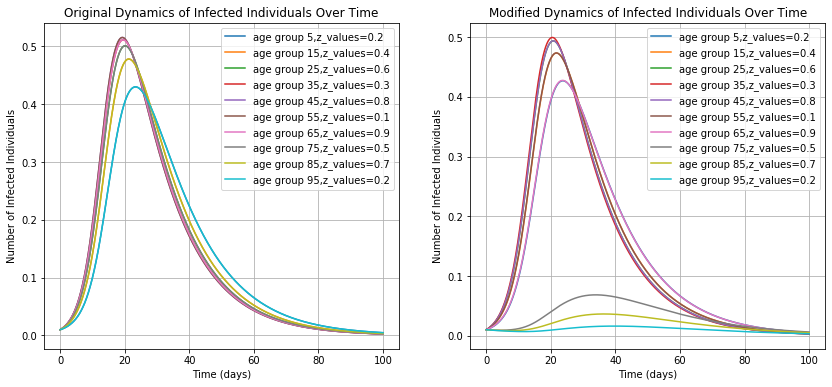

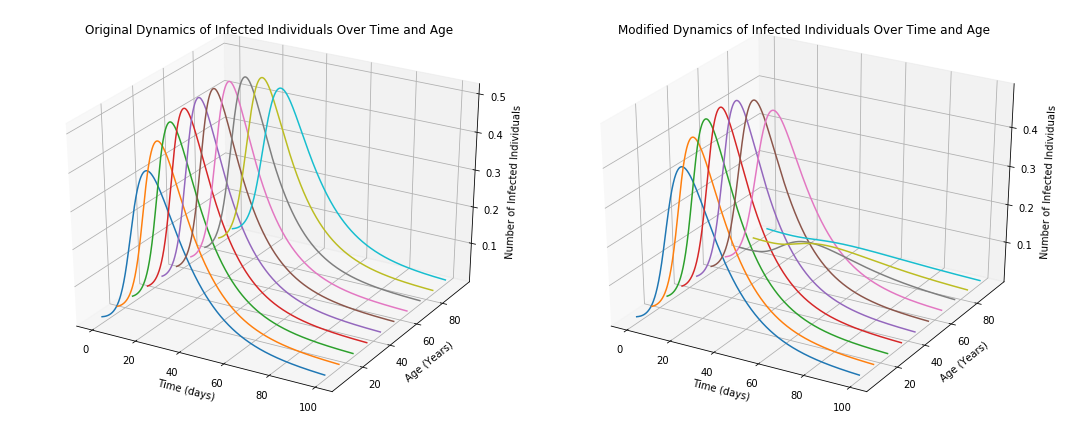

In [10]:
# For Plotting
fig = plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


# Plot for original scenario
for i in range(len(x)):
    ax[0].plot(solution.t, scaled_results_original[i + len(x), :], label=f'age group {x[i]},z_values={z_values[i]}')

ax[0].set_title('Original Dynamics of Infected Individuals Over Time')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Number of Infected Individuals')
ax[0].grid()
ax[0].legend()

fig = plt.figure(figsize=(15, 6))

# Plot for original scenario
ax1 = fig.add_subplot(121, projection='3d')
for i in range(len(x)):
    ax1.plot(solution.t, np.full_like(solution.t, x[i]), scaled_results_original[i + len(x), :])

ax1.set_title('Original Dynamics of Infected Individuals Over Time and Age')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Age (Years)')
ax1.set_zlabel('Number of Infected Individuals')

# Plot for scenario with reducing contact
for i in range(len(x)):
    ax[1].plot(solution_modified.t, scaled_results_modified[i + len(x), :], label=f'age group {x[i]},z_values={z_values[i]}')

ax[1].set_title('Modified Dynamics of Infected Individuals Over Time')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Number of Infected Individuals')
ax[1].grid()
ax[1].legend()
ax2 = fig.add_subplot(122, projection='3d')
for i in range(len(x)):
    ax2.plot(solution_modified.t, np.full_like(solution_modified.t, x[i]), scaled_results_modified[i + len(x), :])

ax2.set_title('Modified Dynamics of Infected Individuals Over Time and Age')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Age (Years)')
ax2.set_zlabel('Number of Infected Individuals')
plt.tight_layout()
plt.show()

In [11]:
peak_infections = [round(np.max(scaled_results_original[i + len(x), :]), 3) for i in range(len(x))]
print("Peak Infections for each age group:", peak_infections)

Peak Infections for each age group: [0.43, 0.478, 0.501, 0.512, 0.516, 0.516, 0.512, 0.501, 0.478, 0.43]


# Calculate Contact matrix

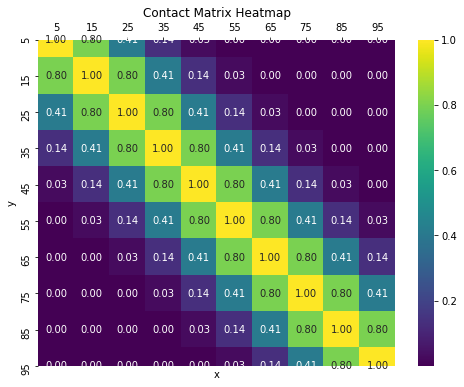

In [12]:
x = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85,95])
y = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85,95])

# Define a function to create a Gaussian kernel
def gaussian_kernel(x, y, sigma=15.0):
    return np.exp(-((x - y) ** 2) / (2.0 * sigma ** 2))

# Create the contact matrix using the Gaussian kernel
sigma = 15.0  # Adjust the standard deviation as needed

# Initialize an empty matrix
contact_matrix = np.zeros((len(x), len(y)))

# Populate the matrix with Gaussian kernel values
for i in range(len(x)):
    for j in range(len(y)):
        contact_matrix[i, j] = gaussian_kernel(x[i], y[j], sigma)

#print("Contact Matrix:")
#print(contact)
# Create heatmap using seaborn
plt.figure(figsize=(8,6))
ax = sns.heatmap(contact_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=x, yticklabels= y)
ax.xaxis.tick_top()
plt.title('Contact Matrix Heatmap')
plt.xlabel('x')
plt.ylabel('y')
plt.show()